<a href="https://colab.research.google.com/github/oyane806/lets-stop-wildfires-hackathon/blob/master/wildfire_smoke_challenge_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import tarfile

In [0]:
bs = 64

In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "/content/gdrive/My Drive/fastai/wildfires/"

# 1. Prepare data

We download data from dropbox and unzip them.

In [6]:
!wget https://www.dropbox.com/s/5rue8c28iidvlvh/grid_smoke_version.tar

--2020-01-07 18:06:18--  https://www.dropbox.com/s/5rue8c28iidvlvh/grid_smoke_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5rue8c28iidvlvh/grid_smoke_version.tar [following]
--2020-01-07 18:06:18--  https://www.dropbox.com/s/raw/5rue8c28iidvlvh/grid_smoke_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5f5a0e79214e10ef686bd9a42.dl.dropboxusercontent.com/cd/0/inline/Avt26wqoAmzKaEn2iiUtjv6E9XnORICPbCfKRAESlejtwCeV6OKI7C5cIqyC6_CVhAUhu4wfCbjc1Dl_z3CKfPtk3gk68lEgHye8UfuAWO-pd8CVDBNUzygAWwzOj4qiIGA/file# [following]
--2020-01-07 18:06:19--  https://uce5f5a0e79214e10ef686bd9a42.dl.dropboxusercontent.com/cd/0/inline/Avt26wqoAmzKaEn2iiUtjv6E9XnORICPbCfKRAESlejtwCeV6OKI7C5cIqyC6_CVhAUhu4wfCbjc1Dl_z

In [0]:
tarred_file = tarfile.open("grid_smoke_version.tar")
tarred_file.extractall()
tarred_file.close()

## Create a validation set with 20% of data from the training set

In [0]:
!mkdir grid_smoke_version/valid
!mkdir grid_smoke_version/valid/grid_smoke
!mkdir grid_smoke_version/valid/grid_no_smoke

In [73]:
!ls grid_smoke_version/train/grid_smoke | wc -l
# I will take 20% in my validation set: that is 200 pictures.

799


In [0]:
!ls grid_smoke_version/train/grid_smoke/* | head -200 | xargs mv -t grid_smoke_version/valid/grid_smoke

In [16]:
!ls grid_smoke_version/train/grid_no_smoke | wc -l
# 525 pictures for the validation set.

2622


In [0]:
!ls grid_smoke_version/train/grid_no_smoke/* | head -525 | xargs mv -t grid_smoke_version/valid/grid_no_smoke

## Load data into a DataBunch

In [0]:
data = ImageDataBunch.from_folder("grid_smoke_version",
                                  train = 'train',
                                  valid='valid',
                                  ds_tfms=get_transforms(), 
                                  size=256, bs=bs).normalize(imagenet_stats)

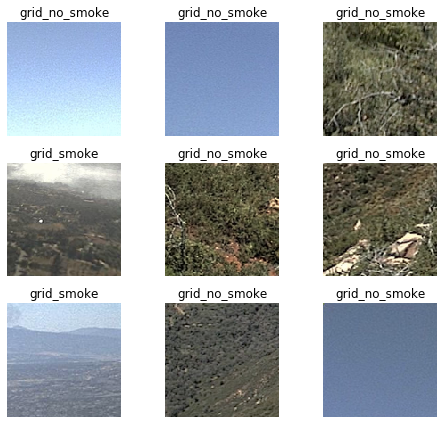

In [112]:
data.show_batch(rows=3, figsize=(7, 6))

# 2. Quick resnet model with pretrained weights

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [92]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.348001,0.356305,0.060690,00:27
1,0.121404,0.520285,0.077241,00:26
2,0.066427,0.555103,0.085517,00:26
3,0.038911,0.561566,0.085517,00:27


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/challenge2-stage-1")

In [115]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.387056,0.286585,0.053793,00:15
1,0.170681,0.500975,0.070345,00:15
2,0.105968,0.444787,0.066207,00:15
3,0.066084,0.452066,0.070345,00:15


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/challenge2-stage-1-size128")

In [118]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.035847,0.430974,0.066207,00:16
1,0.042996,0.419693,0.055172,00:16
2,0.039205,0.491207,0.080000,00:16
3,0.026789,0.486749,0.075862,00:15


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/challenge2-stage-1-size256")

## 👉 Results

After 4 epochs, the error_rate is quite good ! Using grid images is way better than using the full picture!

In [106]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

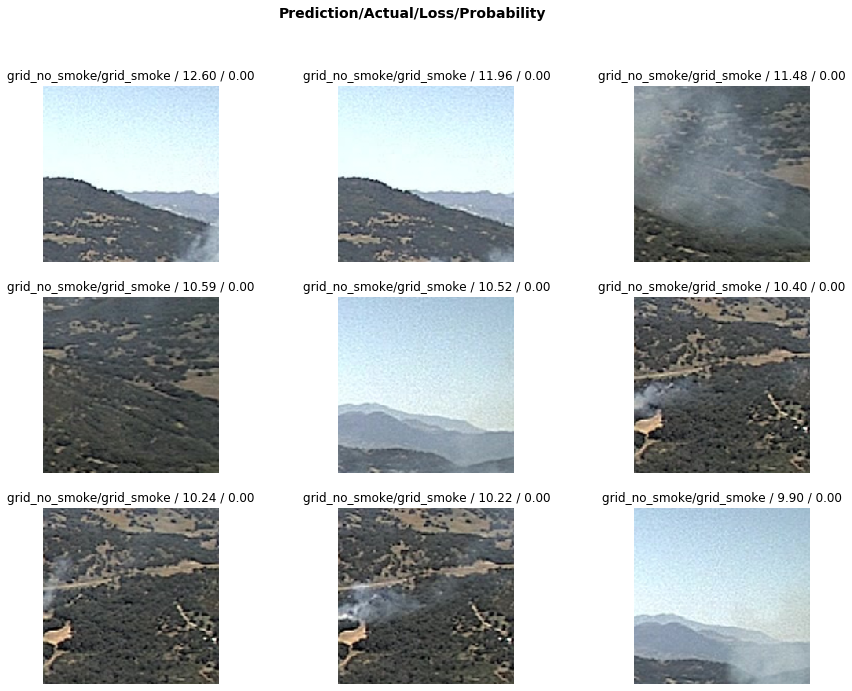

In [97]:
interp.plot_top_losses(9, figsize=(15,11))

By checking a few images wrongly classified, I can see that there is still way for some improvement.

# 3. Resnet model unfreezed

Let's find a good learning rate and improve the error_rate!

In [104]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


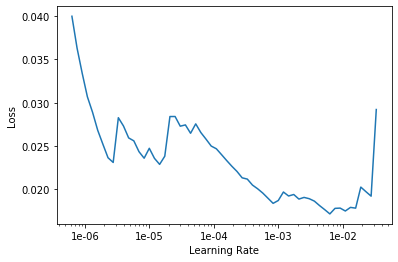

In [86]:
learn.recorder.plot()

In [105]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.028366,0.921854,0.085517,00:27
1,0.076275,0.855137,0.086897,00:27
2,0.046221,0.715430,0.082759,00:27
3,0.018554,0.818743,0.086897,00:28
4,0.007772,0.782088,0.084138,00:27


In [113]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.021418,1.939126,0.089655,00:27
1,0.020782,1.427234,0.088276,00:27
2,0.009919,1.909605,0.091034,00:27
3,0.004471,1.766093,0.091034,00:27
4,0.002214,1.855864,0.091034,00:27


## 👉 Results

Not so good.

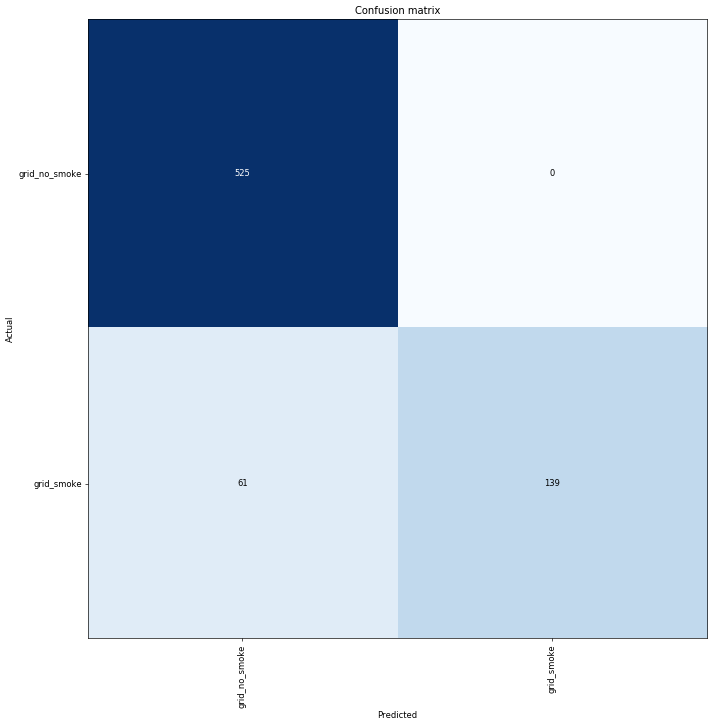

In [107]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)